# RL Recommender System

### Concise version for presentation

In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from typing import Dict, Tuple, List
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Collaborative filtering
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import precision_at_k, train_test_split as implicit_train_test_split
import random

import time
start=time.time()

D:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# IMPROVED PARAMETERS
alpha = 0.15  # Learning rate (increased for faster convergence)
gamma = 0.92  # Discount factor (slightly increased)
epsilon_start = 0.5  # Starting exploration rate
epsilon_end = 0.01  # Final exploration rate
epsilon_decay = 0.995  # Decay rate per episode
num_episodes = 7500 #1200  # Increased number of episodes
window_size = 4  # Increased window size for better context
min_listen_duration = 0.7  # Made less strict for positive reward
max_skip_duration = 0.2  # Made more tolerant for avoiding negative reward, but 0.3 -> 0.2

## Data Exploration

In [3]:
# Load songs from spotify_tracks.csv (same as before)
spotify_df = pd.read_csv("spotify_tracks.csv")
spotify_df.head(n=1).to_dict('index')

{0: {'track_id': '2r0ROhr7pRN4MXDMT1fEmd',
  'track_name': 'Leo Das Entry (From "Leo")',
  'artist_name': 'Anirudh Ravichander',
  'year': 2024,
  'popularity': 59,
  'artwork_url': 'https://i.scdn.co/image/ab67616d0000b273ce9c65e63d5469894b95b4ba',
  'album_name': 'Leo Das Entry (From "Leo")',
  'acousticness': 0.0241,
  'danceability': 0.753,
  'duration_ms': 97297.0,
  'energy': 0.97,
  'instrumentalness': 0.0553,
  'key': 8.0,
  'liveness': 0.1,
  'loudness': -5.994,
  'mode': 0.0,
  'speechiness': 0.103,
  'tempo': 110.997,
  'time_signature': 4.0,
  'valence': 0.459,
  'track_url': 'https://open.spotify.com/track/2r0ROhr7pRN4MXDMT1fEmd',
  'language': 'Tamil'}}

In [4]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62317 entries, 0 to 62316
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          62317 non-null  object 
 1   track_name        62317 non-null  object 
 2   artist_name       62317 non-null  object 
 3   year              62317 non-null  int64  
 4   popularity        62317 non-null  int64  
 5   artwork_url       62317 non-null  object 
 6   album_name        62317 non-null  object 
 7   acousticness      62317 non-null  float64
 8   danceability      62317 non-null  float64
 9   duration_ms       62317 non-null  float64
 10  energy            62317 non-null  float64
 11  instrumentalness  62317 non-null  float64
 12  key               62317 non-null  float64
 13  liveness          62317 non-null  float64
 14  loudness          62317 non-null  float64
 15  mode              62317 non-null  float64
 16  speechiness       62317 non-null  float6

In [5]:
spotify_desc = spotify_df.describe()
spotify_desc

,year,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,62317.000000,62317.000000,62317.000000,62317.000000,6.231700e+04,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000
mean,2014.425935,15.358361,0.362292,0.596807,2.425270e+05,0.602496,0.146215,5.101658,0.194143,-65.103433,0.586052,0.087722,117.931247,3.857086,0.495226
std,9.645113,18.626908,0.314609,0.186209,1.129999e+05,0.246144,0.307804,3.553469,0.172030,2369.051478,0.493682,0.115150,28.509459,0.502660,0.264787
min,1971.000000,0.000000,-1.000000,-1.000000,5.000000e+03,-1.000000,-1.000000,-1.000000,-1.000000,-100000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2011.000000,0.000000,0.067100,0.497000,1.921600e+05,0.440000,0.000000,2.000000,0.093200,-10.727000,0.000000,0.036700,95.942000,4.000000,0.292000
50%,2017.000000,7.000000,0.286000,0.631000,2.362670e+05,0.639000,0.000025,5.000000,0.125000,-7.506000,1.000000,0.048900,117.991000,4.000000,0.507000
75%,2022.000000,26.000000,0.632000,0.730000,2.862400e+05,0.803000,0.015200,8.000000,0.243000,-5.456000,1.000000,0.089100,135.081000,4.000000,0.710000
max,2024.000000,93.000000,0.996000,0.986000,4.581483e+06,1.000000,0.999000,11.000000,0.998000,1.233000,1.000000,0.959000,239.970000,5.000000,0.995000


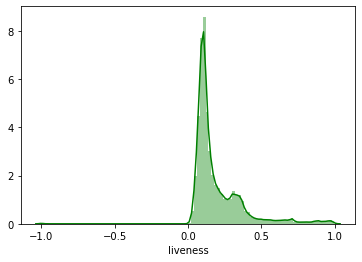

In [6]:
spotify_df['liveness'].describe()
sns.distplot(spotify_df['liveness'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [7]:
print('==================== Numerical Data Features ====================')
spotify_df_num = spotify_df.select_dtypes(include = ['float64', 'int64'])
display(spotify_df_num.head(n=2))

print('\n==================== Non-numerical Data Features ====================')
display(spotify_df.select_dtypes(exclude = ['float64', 'int64']).head(n=2))

==================== Numerical Data Features ====================


,year,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2024,59,0.0241,0.753,97297.0,0.970,0.0553,8.0,0.1000,-5.994,0.0,0.1030,110.997,4.0,0.459
1,2024,47,0.0851,0.780,207369.0,0.793,0.0000,10.0,0.0951,-5.674,0.0,0.0952,164.995,3.0,0.821



==================== Non-numerical Data Features ====================


,track_id,track_name,artist_name,artwork_url,album_name,track_url,language
0,2r0ROhr7pRN4MXDMT1fEmd,"Leo Das Entry (From ""Leo"")",Anirudh Ravichander,https://i.scdn.co/image/ab67616d0000b273ce9c65...,"Leo Das Entry (From ""Leo"")",https://open.spotify.com/track/2r0ROhr7pRN4MXD...,Tamil
1,4I38e6Dg52a2o2a8i5Q5PW,AAO KILLELLE,"Anirudh Ravichander, Pravin Mani, Vaishali Sri...",https://i.scdn.co/image/ab67616d0000b273be1b03...,AAO KILLELLE,https://open.spotify.com/track/4I38e6Dg52a2o2a...,Tamil


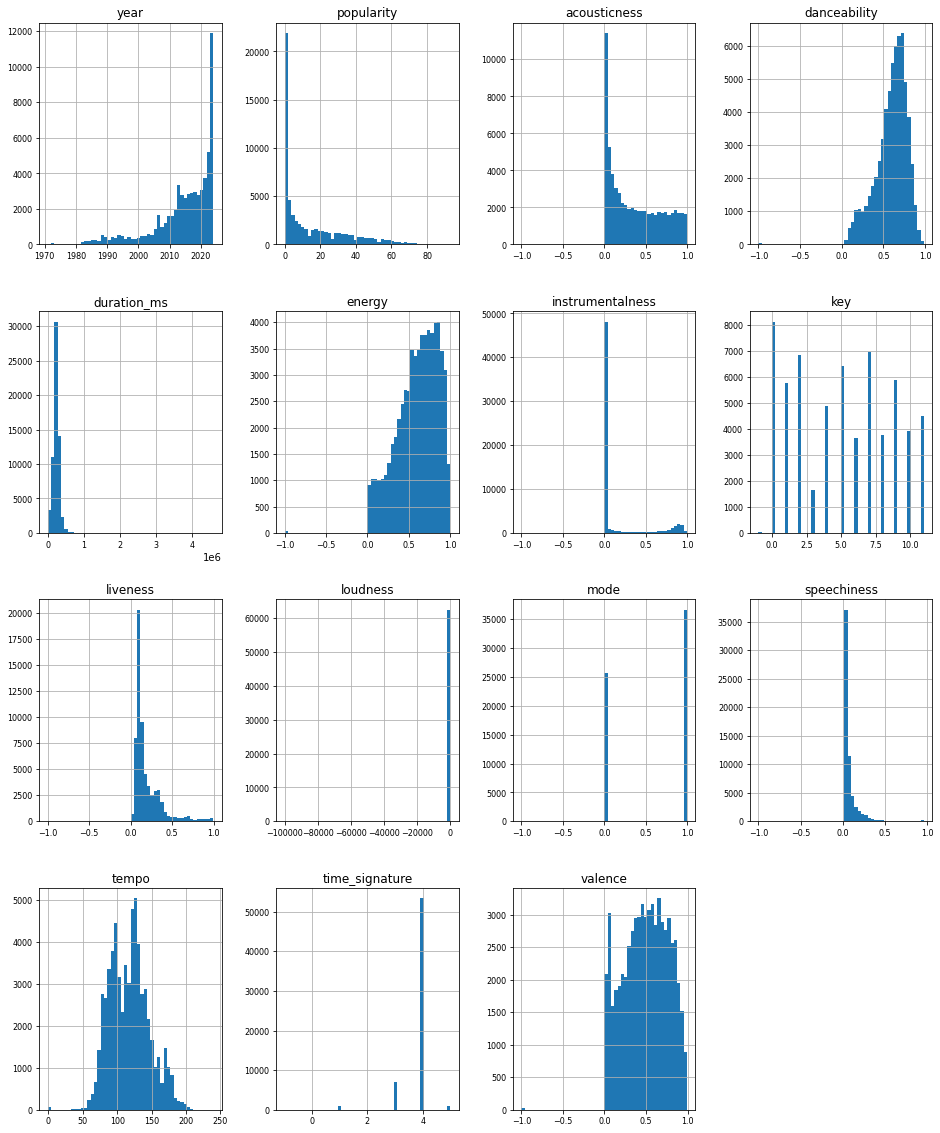

In [8]:
spotify_df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [9]:
#sns.pairplot(spotify_df, hue="mode")

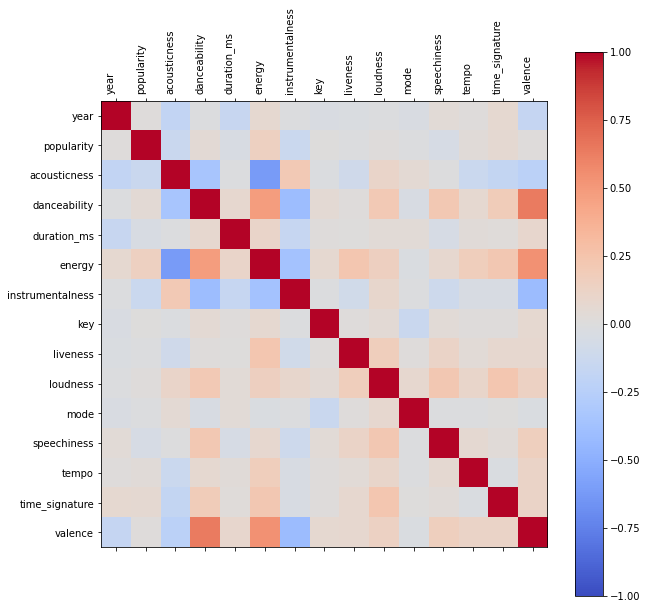

In [10]:
# Check correlation among numerical data
column_labels = spotify_df_num.columns

corr = spotify_df_num.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm',  vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(range(len(column_labels)), labels=column_labels,
              rotation=90, ha="left", rotation_mode="anchor")
ax.set_yticks(range(len(column_labels)), labels=column_labels)
ax.set_xticklabels(column_labels)
ax.set_yticklabels(column_labels)

# Show value inside each grid (takes very long to iterate)
#for (i, j), z in np.ndenumerate(spotify_df_num):
#    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
plt.show()

In [11]:
asc_corr = corr.unstack().sort_values(ascending=True)

# Display top 10 smallest & largest correlations
print(f'Top 10 smallest correlations: {asc_corr[:11]}')
print(f'Top 10 largest correlations excluding 1.0: {asc_corr[-len(column_labels)-11:-len(column_labels)]}') # 15 entries with 1.0

Top 10 smallest correlations: energy            acousticness       -0.615946
acousticness      energy             -0.615946
valence           instrumentalness   -0.412207
instrumentalness  valence            -0.412207
                  danceability       -0.400338
danceability      instrumentalness   -0.400338
energy            instrumentalness   -0.364904
instrumentalness  energy             -0.364904
danceability      acousticness       -0.343135
acousticness      danceability       -0.343135
                  valence            -0.229273
dtype: float64
Top 10 largest correlations excluding 1.0: speechiness     loudness          0.223820
loudness        time_signature    0.229397
time_signature  loudness          0.229397
energy          liveness          0.233556
liveness        energy            0.233556
danceability    energy            0.481835
energy          danceability      0.481835
                valence           0.535278
valence         energy            0.535278
danceabi

In [12]:
# VIF
VIF = [variance_inflation_factor(spotify_df_num.values, i) for i in range(spotify_df_num.shape[1])]
VIF = zip(spotify_df_num.columns, VIF)
collinear_feat = []

# Significant collinearity for features with VIF > 10
print('VIF:')
for k, v in sorted(VIF, key=lambda x: x[1], reverse=True):
    if v >= 10:
        collinear_feat.append(k)
    print(f'{k}: {v:0.4f}')
    
print('===================================================')
print('Features with significant collinearity:')
print(collinear_feat)

VIF:
year: 131.1123
time_signature: 67.4149
danceability: 23.2664
tempo: 19.0401
energy: 17.7994
valence: 9.4119
duration_ms: 5.8601
acousticness: 4.3552
key: 3.1453
liveness: 2.5388
mode: 2.4921
popularity: 1.7752
speechiness: 1.7738
instrumentalness: 1.7301
loudness: 1.3475
Features with significant collinearity:
['year', 'time_signature', 'danceability', 'tempo', 'energy']


In [13]:
# Remove linearly dependent features
#spotify_df.drop(collinear_feat, axis=1, inplace=True)
#spotify_df.shape

## Reinforcement Learning-based Model

In [14]:
# Select random songs with required features
spotify_df = spotify_df.dropna(subset=["track_name",   # drop entire rows with NaN/NA in any of these columns
                                       "artist_name", "duration_ms", "popularity", "tempo"])
selected = spotify_df.sort_values("popularity", ascending=False).head(10).sample(10, random_state=6740)

# Choosing top 10 sorted by popularity may be biased, but a small sample from a predictable set is chosen for simple demonstration

# Q-table initialization
Q: Dict[Tuple, Dict[int, float]] = defaultdict(
    lambda: {action: random.uniform(0, 0.05) for action in songs.keys()}
)
episode_rewards = []

In [15]:
# Enhanced song representation with more features and better feature engineering
songs = {
    i: {
        "name": selected.iloc[i]["track_name"],
        "BPM": selected.iloc[i]["tempo"],
        "genre": selected.iloc[i]["track_genre"] if "track_genre" in selected.columns else "unknown",
        "artist": selected.iloc[i]["artist_name"],
        "duration": selected.iloc[i]["duration_ms"] / 60000,  # convert ms to minutes
        "popularity": selected.iloc[i]["popularity"] / 100,  # normalized popularity
        # Feature engineering: adding more song features if available
        "energy": selected.iloc[i]["energy"] if "energy" in selected.columns else 0.5,
        "danceability": selected.iloc[i]["danceability"] if "danceability" in selected.columns else 0.5,
        "valence": selected.iloc[i]["valence"] if "valence" in selected.columns else 0.5,
        "acousticness": selected.iloc[i]["acousticness"] if "acousticness" in selected.columns else 0.5,
        "instrumentalness": selected.iloc[i]["instrumentalness"] if "instrumentalness" in selected.columns else 0.5,
        "loudness": selected.iloc[i]["loudness"] / -60 if "loudness" in selected.columns else 0.5,  # Normalized loudness
        "key": selected.iloc[i]["key"] / 11 if "key" in selected.columns else 0.5,  # Normalized key
        "mode": selected.iloc[i]["mode"] if "mode" in selected.columns else 0.5,  # Major/minor mode
        "speechiness": selected.iloc[i]["speechiness"] if "speechiness" in selected.columns else 0.3,
        "liveness": selected.iloc[i]["liveness"] if "liveness" in selected.columns else 0.4,
    }
    for i in range(len(selected))
}

In [16]:
# Improved state representation with song feature summaries
def get_state(recent_songs: List[int], user_profile=None) -> Tuple:
    """Enhanced state representation with song features and user profile
        Returns state as a tuple: (
                                    ((sequence of recent songs), (avg_energy, avg_tempo)),
                                    user_profile
                                  )
    """
    # Basic sequence of songs
    song_sequence = tuple(recent_songs[-window_size:])
    
    # Compute aggregate features from recent songs to add context
    if len(recent_songs) > 0:
        avg_energy = np.mean([songs[s]["energy"] for s in recent_songs[-window_size:]])
        avg_tempo = np.mean([songs[s]["BPM"] for s in recent_songs[-window_size:]])
        context = (round(avg_energy, 2), round(avg_tempo/50, 2))
        
        # Include context in state representation
        song_sequence = (*song_sequence, *context)
    
    # If we have a user profile, include it in the state
    if user_profile:
        return (song_sequence, user_profile)
    
    return song_sequence   

# Improved reward function with more nuanced genre and artist continuity rewards
def get_reward(song_id: int, duration_listened: float, previous_song_id=None) -> float:
    base_reward = 0.0
    
    # Base reward based on listening duration with smoother scaling
    listen_ratio = duration_listened / songs[song_id]["duration"]
    
    if listen_ratio >= min_listen_duration:
        # Smooth reward scaling based on listen duration
        base_reward = 0.5 + 0.5 * min(1, (listen_ratio - min_listen_duration) / (1 - min_listen_duration))
    elif listen_ratio <= max_skip_duration:
        # Penalize skips with smooth negative scaling
        base_reward = -1.0 + listen_ratio / max_skip_duration
    else:
        # Neutral zone gets a small positive reward
        base_reward = 0.2 * (listen_ratio - max_skip_duration) / (min_listen_duration - max_skip_duration)
    
    # Additional rewards for continuity (if previous song exists)
    continuity_reward = 0.0
    if previous_song_id is not None:
        # Genre continuity reward
        if songs[song_id]["genre"] == songs[previous_song_id]["genre"]:
            continuity_reward += 0.25
        
        # Artist continuity reward (if user likes to listen to the same artist consecutively)
        if songs[song_id]["artist"] == songs[previous_song_id]["artist"]:
            continuity_reward += 0.15
        
        # BPM/tempo similarity reward (reward songs with similar tempo)
        bpm_diff = abs(songs[song_id]["BPM"] - songs[previous_song_id]["BPM"])
        if bpm_diff < 10:  # Small BPM difference
            continuity_reward += 0.15
        elif bpm_diff < 20:  # Moderate BPM difference
            continuity_reward += 0.05
            
        ### Instead of arbitrary values, using 1 or 1/2 standard deviation could be a good diff
        # Mood continuity (valence similarity)
        valence_diff = abs(songs[song_id]["valence"] - songs[previous_song_id]["valence"])
        if valence_diff < 0.2:
            continuity_reward += 0.15
        
        # Energy continuity
        energy_diff = abs(songs[song_id]["energy"] - songs[previous_song_id]["energy"])
        if energy_diff < 0.2:
            continuity_reward += 0.1
            
        # Consider more features, some relying on standard deviation as threshold
        # Instrumentalness continuity
        inst_diff = abs(songs[song_id]["instrumentalness"] - songs[previous_song_id]["instrumentalness"])
        if inst_diff < 0.2:
            continuity_reward += 0.1
            
        # Speechiness continuity
        speech_diff = abs(songs[song_id]["speechiness"] - songs[previous_song_id]["speechiness"])
        if speech_diff < 0.2:
            continuity_reward += 0.12
            
        # Liveness continuity
        liveness_diff = abs(songs[song_id]["liveness"] - songs[previous_song_id]["liveness"])
        if liveness_diff < spotify_desc['liveness']['std']:
            continuity_reward += 0.12
            
        # Loudness continuity
        loudness_diff = abs(songs[song_id]["loudness"] - songs[previous_song_id]["loudness"])
        if loudness_diff < spotify_desc['loudness']['std']:
            continuity_reward += 0.12
            
        # Acousticness continuity
        acoustic_diff = abs(songs[song_id]["acousticness"] - songs[previous_song_id]["acousticness"])
        if acoustic_diff < spotify_desc['acousticness']['std']:
            continuity_reward += 0.12
    
    return base_reward + continuity_reward

In [17]:
# Training with decaying epsilon and improved exploration strategy
epsilon = epsilon_start   # 0.5, Starting exploration rate
for episode in range(num_episodes):
    recent_songs = random.sample(list(songs.keys()), window_size)   # 4 songs in window
    state = get_state(recent_songs)   # state = (((sequence of recent songs), (avg_energy, avg_tempo)), user_profile)
    total_reward = 0.0

    for step in range(10):
        # Epsilon-greedy action selection with decaying epsilon
        if random.uniform(0, 1) < epsilon:
            # Improved exploration strategy - biased toward high energy/popularity songs initially
            if episode < num_episodes * 0.3:  # First 30% of episodes
                action_scores = {s: songs[s]["energy"] * songs[s]["popularity"] for s in songs.keys()}
                action = random.choices(
                    list(action_scores.keys()), 
                    weights=list(action_scores.values()), 
                    k=1
                )[0]
            else:
                action = random.choice(list(songs.keys()))
        else:
            action = max(Q[state].items(), key=lambda x: x[1])[0]

        # Simulate user listening with more dynamic behavior
        listen_prob = 0.7 + 0.3 * songs[action]["popularity"]  # Popular songs more likely to be heard longer
        duration_listened = random.betavariate(listen_prob*2, 2-listen_prob) * songs[action]["duration"]
        
        # Get previous song for continuity rewards
        previous_song = recent_songs[-1] if recent_songs else None
        reward = get_reward(action, duration_listened, previous_song)
        total_reward += reward

        # Transition to next state
        next_recent_songs = recent_songs[1:] + [action]
        next_state = get_state(next_recent_songs)
        
        # Q-learning update with double Q-learning logic to prevent overestimation
        best_next_action = max(Q[next_state].items(), key=lambda x: x[1])[0] if next_state in Q else 0
        best_next_q = Q[next_state][best_next_action] if next_state in Q else 0
        
        # Update Q-value with dynamic learning rate that decreases for stable states
        state_visits = len(Q[state])
        adaptive_alpha = alpha / (1 + 0.1 * state_visits)  # Adaptive learning rate
        Q[state][action] += adaptive_alpha * (reward + gamma * best_next_q - Q[state][action])

        state = next_state
        recent_songs = next_recent_songs

    # Decay epsilon with a floor to maintain some exploration
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

In [18]:
# Improved evaluation
def evaluate_rl(Q: Dict[Tuple, Dict[int, float]], num_test_episodes=100):
    correct_recommendations = 0
    total_recommendations = 0
    rewards = []
    y_true = []
    y_pred = []
    confidence_scores = []

    for _ in range(num_test_episodes):
        recent_songs = random.sample(list(songs.keys()), window_size)
        state = get_state(recent_songs)
        episode_reward = 0.0

        for _ in range(10):
            # Get actions and their Q-values
            q_values = list(Q[state].items())
            
            # Sort actions by Q-value
            sorted_actions = sorted(q_values, key=lambda x: x[1], reverse=True)
            action = sorted_actions[0][0]  # Best action
            
            # Calculate confidence score using softmax
            q_values_array = np.array([q[1] for q in q_values])
            # Apply temperature scaling to softmax for better confidence calibration
            temperature = 0.5
            confidence = np.exp(q_values_array/temperature) / np.sum(np.exp(q_values_array/temperature))
            action_confidence = confidence[list(Q[state].keys()).index(action)]
            
            # Simulate user listening
            duration_listened = random.uniform(0, songs[action]["duration"])
            previous_song = recent_songs[-1] if recent_songs else None
            reward = get_reward(action, duration_listened, previous_song)
            episode_reward += reward

            # Only predict 1 if the model is confident enough
            prediction = 1 if action_confidence > 0.55 else 0
            actual = 1 if reward > 0 else 0
            
            y_true.append(actual)
            y_pred.append(prediction)
            confidence_scores.append(action_confidence)

            # Track if recommendation was correct
            if reward > 0 and prediction == 1:
                correct_recommendations += 1
            if prediction == 1:  # Count only when we actually recommend
                total_recommendations += 1

            recent_songs = recent_songs[1:] + [action]
            state = get_state(recent_songs)

        rewards.append(episode_reward)

    # Avoid division by zero
    if total_recommendations == 0:
        accuracy = 0
    else:
        accuracy = correct_recommendations / total_recommendations
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    return {
        "RL Accuracy": accuracy,
        "RL Score Accuracy": acc,
        "RL Avg Reward": np.mean(rewards),
        "RL Precision": precision,
        "RL F1": f1,
        "RL Avg Confidence": np.mean(confidence_scores)
    }

In [19]:
rl_metrics = evaluate_rl(Q)
rl_metrics

{'RL Accuracy': 0.9910485933503836,
 'RL Score Accuracy': 0.775,
 'RL Avg Reward': 11.570054679381064,
 'RL Precision': 0.9910485933503836,
 'RL F1': 0.8732394366197184,
 'RL Avg Confidence': 0.779563291431188}

In [24]:
# RL simulation & evaluation

def simulate_user_interaction(Q: Dict[Tuple, Dict[int, float]], songs: Dict[int, Dict], window_size: int = 4):
    """Interactive simulation where you (the user) listen/skip songs, and the RL model responds."""
    # Initialize recent songs with random history
    rewards_history = []
    max_rewards_history = []
    songs_history = []
    states_history = []
    recent_songs: List[int] = random.sample(list(songs.keys()), window_size)
    state = get_state(recent_songs)
    
    print("=== RL Music Recommender Simulation ===")
    print("Type 'listen' to hear the song, 'skip' to reject it, 'soso' to skip after about halfway, or 'quit' to exit.\n")
    
    while True:
        # Get the RL model's recommended action (song)
        if state in Q:
            action = max(Q[state].items(), key=lambda x: x[1])[0]  # Greedy policy
        else:
            action = random.choice(list(songs.keys()))  # Fallback for unseen states
        
        song = songs[action]
        songs_history.append(song['name'])   # keep track of recommended songs
        print(f"\nRecommended: {song['name']} by {song['artist']}")
        print(f"Features: BPM={song['BPM']}, Energy={song['energy']:.2f}, Popularity={song['popularity']:.2f}")
        
        # Simulate user feedback
        while True:
            feedback = input("Seconds listened (i.e. 2 or 120.5) or '-1' to exit: ")#.strip().lower()
            try:
                feedback = float(feedback)/60   # convert to minutes
                break
            except ValueError as e:
                print(f"Invalid input. Try again.")
        if feedback < 0:
            print("\nSimulation ended.")
            print("Song & reward history:")
            for s, r in zip(songs_history, rewards_history):
                print(f"{s}  -  {r:.4f}")
            # Overall performance measured by actual score / maximum possible score
            print("Overall performance (rewards/max_rewards):")
            print(f"{sum(rewards_history) / sum(max_rewards_history):.4f}")
            break
        
        # Update state based on feedback
        """
        if feedback == "listen":
            duration_listened = song["duration"] * 0.7  # Simulate listening to 70% of the song
            reward = get_reward(action, duration_listened, recent_songs[-1] if recent_songs else None)
            print(f"You listened! Reward: {reward:.2f}")
        elif feedback == "soso":
            duration_listened = song["duration"] * 0.45  # Simulate listening to about 45% of the song
            reward = get_reward(action, duration_listened, recent_songs[-1] if recent_songs else None)
            print(f"You listened! Reward: {reward:.2f}")
        else:
            duration_listened = song["duration"] * 0.15  # Simulate skipping after 15%
            reward = get_reward(action, duration_listened, recent_songs[-1] if recent_songs else None)
            print(f"You skipped. Reward: {reward:.2f}")
        """
        reward = get_reward(action, feedback, recent_songs[-1] if recent_songs else None)
        rewards_history.append(reward)
        max_rewards_history.append(get_reward(action, songs[action]['duration'], recent_songs[-1] if recent_songs else None))
        print(f"Song complete! Reward: {reward:.2f}")
        
        # Update recent songs and state
        recent_songs = recent_songs[1:] + [action]
        state = get_state(recent_songs)
    
    
    

# Example usage
if __name__ == "__main__":
    simulate_user_interaction(Q, songs, window_size=4)

=== RL Music Recommender Simulation ===
Type 'listen' to hear the song, 'skip' to reject it, 'soso' to skip after about halfway, or 'quit' to exit.


Recommended: Blinding Lights by The Weeknd
Features: BPM=171.005, Energy=0.73, Popularity=0.91


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  125


Song complete! Reward: 0.98

Recommended: Locked out of Heaven by Bruno Mars
Features: BPM=143.994, Energy=0.70, Popularity=0.88


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: -0.19

Recommended: Big Dawgs by Hanumankind, Kalmi
Features: BPM=180.098, Energy=0.74, Popularity=0.93


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  125


Song complete! Reward: 1.11

Recommended: Big Dawgs by Hanumankind, Kalmi
Features: BPM=180.098, Energy=0.74, Popularity=0.93


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: 0.38

Recommended: Anti-Hero by Taylor Swift
Features: BPM=97.008, Energy=0.64, Popularity=0.89


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  125


Song complete! Reward: 0.98

Recommended: cardigan by Taylor Swift
Features: BPM=130.033, Energy=0.58, Popularity=0.89


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  120


Song complete! Reward: 1.23

Recommended: Blinding Lights by The Weeknd
Features: BPM=171.005, Energy=0.73, Popularity=0.91


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  60


Song complete! Reward: 0.85

Recommended: Blinding Lights by The Weeknd
Features: BPM=171.005, Energy=0.73, Popularity=0.91


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: 0.38

Recommended: Bye Bye Bye - From Deadpool and Wolverine Soundtrack by *NSYNC
Features: BPM=172.638, Energy=0.93, Popularity=0.90


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  180


Song complete! Reward: 1.91

Recommended: Blinding Lights by The Weeknd
Features: BPM=171.005, Energy=0.73, Popularity=0.91


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: 0.08

Recommended: Big Dawgs by Hanumankind, Kalmi
Features: BPM=180.098, Energy=0.74, Popularity=0.93


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: 0.11

Recommended: Blinding Lights by The Weeknd
Features: BPM=171.005, Energy=0.73, Popularity=0.91


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: 0.11

Recommended: Big Dawgs by Hanumankind, Kalmi
Features: BPM=180.098, Energy=0.74, Popularity=0.93


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: 0.11

Recommended: Starboy by The Weeknd, Daft Punk
Features: BPM=186.003, Energy=0.59, Popularity=0.91


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: -0.04

Recommended: Anti-Hero by Taylor Swift
Features: BPM=97.008, Energy=0.64, Popularity=0.89


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: -0.04

Recommended: Is It Over Now? (Taylor's Version) (From The Vault) by Taylor Swift
Features: BPM=100.012, Energy=0.66, Popularity=0.88


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  100


Song complete! Reward: 1.32

Recommended: cardigan by Taylor Swift
Features: BPM=130.033, Energy=0.58, Popularity=0.89


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  0


Song complete! Reward: -0.04

Recommended: Is It Over Now? (Taylor's Version) (From The Vault) by Taylor Swift
Features: BPM=100.012, Energy=0.66, Popularity=0.88


Seconds listened (i.e. 2 or 120.5) or '-1' to exit:  -1



Simulation ended.
Song & reward history:
Blinding Lights  -  0.9800
Locked out of Heaven  -  -0.1900
Big Dawgs  -  1.1122
Big Dawgs  -  0.3800
Anti-Hero  -  0.9791
cardigan  -  1.2304
Blinding Lights  -  0.8500
Blinding Lights  -  0.3800
Bye Bye Bye - From Deadpool and Wolverine Soundtrack  -  1.9103
Blinding Lights  -  0.0800
Big Dawgs  -  0.1100
Blinding Lights  -  0.1100
Big Dawgs  -  0.1100
Starboy  -  -0.0400
Anti-Hero  -  -0.0400
Is It Over Now? (Taylor's Version) (From The Vault)  -  1.3243
cardigan  -  -0.0400
Overall performance (rewards/max_rewards):
0.2669


In [26]:
print("Total time in seconds for each song:")
for s in songs.values():
    print(f"{s['name']} - {s['duration']*60}")

Total time in seconds for each song:
Bye Bye Bye - From Deadpool and Wolverine Soundtrack - 200.39999999999998
Blinding Lights - 200.04
EASY - 164.54500000000002
august - 261.923
Big Dawgs - 190.667
Anti-Hero - 200.69
Is It Over Now? (Taylor's Version) (From The Vault) - 229.478
Starboy - 230.453
cardigan - 239.56
Locked out of Heaven - 233.478
